In [247]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

## 3.5.3 Gradient Boosting Guided Example and Challenge

### Gradient boosting guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [248]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [249]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)


In [250]:
# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04609929078014184
Percent Type II errors: 0.17757774140752863

Test set accuracy:
Percent Type I errors: 0.05276073619631902
Percent Type II errors: 0.18773006134969325


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

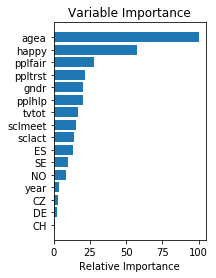

In [251]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [252]:
feature_importance

array([  3.50458481,  17.16950591,  21.9655852 ,  28.16085081,
        20.1262185 ,  57.5122793 ,  15.65724381,  13.97991887,
        20.29594867, 100.        ,   1.20621248,   3.08694459,
         2.23935062,  13.37131282,   8.24644623,  10.15523883])

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

### Start of Challenge:

__Approach #1: Up sample the minority class__

Upsample after splitting data into train/test set.

In [253]:
# Inspect class imbalance in full dataset
print((df['partner']).value_counts())

1.0    5013
2.0    3134
Name: partner, dtype: int64


In [236]:
# Grab X and Y from above to reset data processing
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.1, 
                                                    random_state=42)

In [237]:
# Recombine X and y training data sets so we can upsample
# Convert y_train back into a data frame
y_train_df = y_train.to_frame()

# Join with X_train to create a full training data set with predictors and outcome variable
training = y_train_df.join(X_train)

# Look at class imbalance in training dataset
print((training['partner']).value_counts())

0.0    4520
1.0    2812
Name: partner, dtype: int64


In [238]:
# Separate training data into majority and minority classes
training_minority = training[training.partner==1]
training_majority = training[training.partner==0]

# Import library
from sklearn.utils import resample

# Upsample minority class. Set n equal to training set majority class
training_minority_upsampled = resample(training_minority,
                                      replace = True, 
                                      n_samples = 4520,
                                      random_state = 123)

# Combine majority class with upsampled minority class
training_upsampled = pd.concat([training_majority, training_minority_upsampled])

# Display new class counts
training_upsampled.partner.value_counts()

1.0    4520
0.0    4520
Name: partner, dtype: int64

In [239]:
training.head()

,partner,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,CH,CZ,DE,ES,NO,SE
4860,0.0,7,7.0,5.0,5.0,5.0,8.0,4.0,3.0,1.0,41.0,0,0,0,1,0,0
3257,1.0,6,4.0,8.0,8.0,8.0,9.0,7.0,3.0,2.0,18.0,0,0,0,1,0,0
82,1.0,6,2.0,4.0,5.0,5.0,9.0,7.0,3.0,2.0,35.0,1,0,0,0,0,0
1828,0.0,6,7.0,8.0,9.0,3.0,7.0,6.0,1.0,2.0,25.0,0,1,0,0,0,0
674,1.0,6,1.0,3.0,6.0,4.0,7.0,5.0,3.0,2.0,20.0,1,0,0,0,0,0


In [240]:
# Break training set back into X_train and y_train
X_train_upsampled = training.drop(['partner'], 1)
y_train_upsampled = training['partner']

In [244]:
# Rerun model with same settings as above
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf2 = ensemble.GradientBoostingClassifier(**params)
clf2.fit(X_train_upsampled, y_train_upsampled)

predict_train = clf2.predict(X_train_upsampled)
predict_test = clf2.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train_upsampled, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04609929078014184
Percent Type II errors: 0.17757774140752863

Test set accuracy:
Percent Type I errors: 0.05276073619631902
Percent Type II errors: 0.18773006134969325


Upsampling the minority class did not improve either type error.

__Approach #2: Increase iterations__

In [245]:
# Keep upsampled data
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf3 = ensemble.GradientBoostingClassifier(**params)
clf3.fit(X_train_upsampled, y_train_upsampled)

predict_train = clf3.predict(X_train_upsampled)
predict_test = clf3.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train_upsampled, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04487179487179487
Percent Type II errors: 0.16953082378614293

Test set accuracy:
Percent Type I errors: 0.05644171779141104
Percent Type II errors: 0.18527607361963191


In [254]:
# Get rid of upsampled data
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf4 = ensemble.GradientBoostingClassifier(**params)
clf4.fit(X_train, y_train)

predict_train = clf4.predict(X_train)
predict_test = clf4.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04487179487179487
Percent Type II errors: 0.16953082378614293

Test set accuracy:
Percent Type I errors: 0.05644171779141104
Percent Type II errors: 0.18527607361963191


Doubling the number of iterations did not significantly improve the accuracy.  There was absolutely no difference between the test and upsampled test datasets.  Possible error here?

__Approach #3: Increase max depth__

In [256]:
# Set parameters
params = {'n_estimators': 1000,
          'max_depth': 4,
          'loss': 'deviance'}

# Initialize and fit the model.
clf5 = ensemble.GradientBoostingClassifier(**params)
clf5.fit(X_train, y_train)

predict_train = clf5.predict(X_train)
predict_test = clf5.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.011320240043644299
Percent Type II errors: 0.08333333333333333

Test set accuracy:
Percent Type I errors: 0.08098159509202454
Percent Type II errors: 0.17423312883435582


Increasing max depth resulted in overfitting. 

Overall, was not successful in improving the model accuracy in any of the 3 approaches tried.